In [2]:
import pandas as pd
from pybaseball import statcast_batter, statcast_pitcher, playerid_lookup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb

In [3]:
#if you want to run the model on a different player, simply look up his mlbam key using this function and replace
#it in place of Votto's into the statcast_batter function in the line below
playerid_lookup('votto','joey')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,votto,joey,458015,vottj001,vottojo01,4314,2007.0,2020.0


In [4]:
#getting Joey Votto's pitch by pitch data over the last 5 years
data0 = statcast_batter('2015-03-15','2020-09-08',458015)

Gathering Player Data


In [5]:
data0.shape

(14198, 89)

In [6]:
#removing intentional balls and pitchouts because they are not trying to get the batter to swing
data1 = data0.loc[(data0['description']!= 'intent_ball') & (data0['pitch_type']!= 'PO')]

In [7]:
data1.shape

(14080, 89)

In [8]:
data1['plate_z'].isna().sum()

77

In [9]:
#removing rows without pitch location data
data2 = data1.loc[(data1['plate_x'].notnull()) & (data1['plate_z'].notnull())]

In [10]:
data2.shape

(14003, 89)

In [11]:
data2['pitch_type'].isna().sum()

14

In [12]:
data2['release_speed'].isna().sum()

10

In [13]:
data3 = data2.loc[(data2['pitch_type'].notnull()) & (data2['release_speed'].notnull())]

In [14]:
data3.shape

(13989, 89)

In [19]:
pd.set_option('display.max_columns', None)

In [21]:
#indicating whether or not the batter swung (1 indicates swing, 0 indicates take)
data3['swing'] = 1

/Users/jeremiahwilson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
data3['description'].unique()

array(['hit_into_play', 'called_strike', 'ball', 'blocked_ball',
       'swinging_strike', 'swinging_strike_blocked', 'foul',
       'hit_into_play_no_out', 'foul_tip', 'hit_into_play_score',
       'hit_by_pitch', 'foul_bunt', 'pitchout', 'missed_bunt'],
      dtype=object)

In [23]:
#setting the swing column equal to 0 on all pitches the batter did not swing at
data3.loc[data3['description'].isin(['ball','called_strike','blocked_ball','hit_by_pitch',
                                    'pitchout']),'swing'] = 0

/Users/jeremiahwilson/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
#resetting the index and reversing it so the pitches are ordered chronologically
data4 = data3.iloc[::-1].reset_index(drop = True)

In [25]:
data4.pitch_type.unique()

array(['FT', 'SL', 'SI', 'FF', 'CH', 'KC', 'FC', 'CU', 'FS', 'KN', 'FO'],
      dtype=object)

In [26]:
#categorizing pitches as either fastballs, breaking balls, or offspeed pitches
fastballs = ['FF','FT','SI', 'FC']
breaking = ['CU','SL','KC','KN','FS','SC']
offspeed = ['CH','FO','EP']

In [27]:
#creating a new column that indicates what the previous pitch thrown was. Default value is 'none'
data4['prev_pitch'] = 'none'   

In [28]:
#creating a loop that imputes the previous pitch type into our new 'prev_pitch' column (if one was thrown)
prev_pitch_list = []
for i in range(len(data4)):
    
    #skipping if it is the first pitch of the at-bat because there is no previous pitch
    if data4['pitch_number'][i] == 1:
        previous_pitch = 'none'
    
    elif data4['pitch_number'][i]!= 1:
        #getting the pitch type that was thrown in the previous pitch
        previous_pitch = data4['pitch_type'][i-1]
    
    prev_pitch_list.append(previous_pitch)

In [29]:
#setting the prev_pitch column equal to the list we created above
data4['prev_pitch'] = prev_pitch_list

In [30]:
#recategorizing the pitch types into fastballs, breaking balls, and offspeed pitches using the lists I made earlier
data4.loc[data4['prev_pitch'].isin(fastballs),'prev_pitch'] = 'fb'
data4.loc[data4['prev_pitch'].isin(breaking),'prev_pitch'] = 'brk'
data4.loc[data4['prev_pitch'].isin(offspeed),'prev_pitch'] = 'offs'

In [31]:
#getting only the columns we will need in our model
relevant_df = data4[['plate_x','plate_z','release_speed','p_throws','pfx_x','pfx_z','vx0','vy0','vz0',
                  'strikes','balls','prev_pitch', 'swing']]

In [33]:
relevant_df.head()

,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,prev_pitch,swing
0,-0.83,3.37,95.1,L,1.3,1.3,-9.920,-138.021,-4.103,0,0,none,0
1,0.19,3.45,94.4,L,1.0,1.1,-6.567,-137.249,-3.013,0,1,fb,0
2,-1.96,1.69,87.2,L,0.0,0.3,-8.554,-126.598,-4.632,1,1,fb,1
3,-0.72,0.48,89.4,L,-0.1,1.3,-6.653,-129.696,-9.990,2,1,brk,0
4,-0.90,2.27,95.7,L,1.1,0.9,-9.130,-138.941,-6.085,2,2,brk,1


In [34]:
#one-hot encoding our categorical features
hot_df = pd.get_dummies(relevant_df, prefix = ['throws_','prev_'])

In [35]:
#separating our dependent variable
y = hot_df['swing']
y = y.astype(int)

In [37]:
#getting our independent variables
x = hot_df.drop('swing', axis = 1).values

In [38]:
#splitting our test and training data
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [39]:
#initializing our model
clf = lgb.LGBMClassifier()

In [40]:
#training our model
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
#predicting
y_pred=clf.predict(X_test)

In [42]:
#getting our accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)

In [43]:
accuracy

0.7952108649035025

In [44]:
#predicting the training data
y_pred_train = clf.predict(X_train)

In [45]:
print('Training-set accuracy score: {0:0.4f}'.format(metrics.accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8674


In [46]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.8674
Test set score: 0.7952


In [47]:
#getting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n',cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1374  273]
 [ 300  851]]

True Positives(TP) =  1374

True Negatives(TN) =  851

False Positives(FP) =  273

False Negatives(FN) =  300


In [197]:
#lets try some hyperparameter tuning
clf2 = lgb.LGBMClassifier(boosting_type='gbdt',
    objective = 'binary',
    learning_rate = 0.099,
    max_depth = 6,
    num_leaves = 26,
    n_estimators = 180)

In [198]:
#training new model
clf2.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.099, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=180, n_jobs=-1, num_leaves=26, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [199]:
#predicting with new model
y_pred2=clf2.predict(X_test)

In [200]:
#new model accuracy
accuracy2 = metrics.accuracy_score(y_pred2, y_test)

In [201]:
accuracy2

0.8052180128663331

In [203]:
print('Training set score: {:.4f}'.format(clf2.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf2.score(X_test, y_test)))

Training set score: 0.8704
Test set score: 0.8052


In [204]:
#confusion matrix for new model
cm2 = metrics.confusion_matrix(y_test, y_pred2)

In [205]:
#comparing these to the last model, it looks like we saw a very slight increase in the ability to classify
#swings and a more substantial increase in the ability to correctly classify takes
print('Confusion matrix\n\n',cm2)
print('\nTrue Positives(TP) = ', cm2[0,0])
print('\nTrue Negatives(TN) = ', cm2[1,1])
print('\nFalse Positives(FP) = ', cm2[0,1])
print('\nFalse Negatives(FN) = ', cm2[1,0])

Confusion matrix

 [[1377  270]
 [ 275  876]]

True Positives(TP) =  1377

True Negatives(TN) =  876

False Positives(FP) =  270

False Negatives(FN) =  275


In [206]:
#getting list of column names
col_names = hot_df.drop('swing',axis= 1).columns

In [207]:
#putting the test data back into a dataframe so I can manipulate it
test_df2 = pd.DataFrame(data = X_test, columns = col_names)

In [208]:
#putting the predicted probabilities into a df
gb_prob_df2 = pd.DataFrame(data = clf2.predict_proba(X_test), columns = ['take_probability',
                                                                       'swing_probability'])

In [209]:
#adding the swing probability to the df with our test data
test_df2['swing_probability'] = gb_prob_df2['swing_probability']

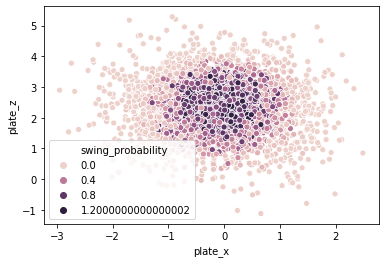

In [210]:
#plotting the location of each pitch along with its swing probability  
sns.scatterplot(x = test_df2['plate_x'],y = test_df2['plate_z'],hue = test_df2['swing_probability'])

In [211]:
#we are gonna test out our model on Tyler Glasnow's pitches
glasnow = statcast_pitcher('2019-03-15','2020-09-10',607192)

Gathering Player Data


In [212]:
#getting everytime his curveball was thrown
tg_cu = glasnow.loc[glasnow['pitch_type']=='CU']

In [213]:
#getting the average speed of his curveball to use in our test
tg_avg_speed = tg_cu['release_speed'].mean()

In [214]:
tg_avg_pfx_x = tg_cu['pfx_x'].mean()
tg_avg_pfx_z = tg_cu['pfx_z'].mean()
tg_avg_vx0 = tg_cu['vx0'].mean()
tg_avg_vy0 = tg_cu['vy0'].mean()
tg_avg_vz0 = tg_cu['vz0'].mean()
#these will be used as the x,z coordinates for the strikezone
tg_plate_x = np.linspace(start = -1.5, stop = 1.5, num = 40)
tg_plate_z = np.linspace(start = 0.5, stop = 4, num = 50)

In [215]:
#getting the cartesian product of those two arrays
plate_product = np.transpose([np.tile(tg_plate_x, len(tg_plate_z)), np.repeat(tg_plate_z, len(tg_plate_x))])

In [216]:
tg_df = pd.DataFrame(data = plate_product, columns = ['plate_x','plate_z'])

In [217]:
#adding the rest of the features and setting their values to the average
tg_df['release_speed']= tg_avg_speed
tg_df['pfx_x']= tg_avg_pfx_x
tg_df['pfx_z']= tg_avg_pfx_z
tg_df['vx0']= tg_avg_vx0
tg_df['vy0']= tg_avg_vy0
tg_df['vz0']= tg_avg_vz0
tg_df['strikes']=0
tg_df['balls']=0
tg_df['throws_L']=0
tg_df['throws_R']=1
tg_df['prev_brk']=0
tg_df['prev_fb']=0
tg_df['prev_none']=1
tg_df['prev_offs']=0

In [218]:
#getting probabilities for Glasnow's curveball
swing_prob = clf2.predict_proba(tg_df.values)

In [221]:
tg_sp = pd.DataFrame(data = swing_prob, columns = ['take_prob','swing_prob'])

In [222]:
tg_df['swing_prob'] = tg_sp['swing_prob']

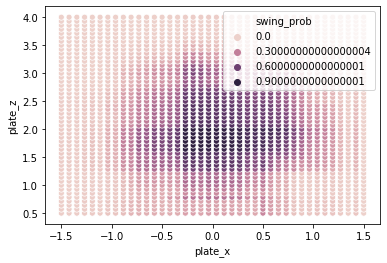

In [223]:
sns.scatterplot(x = tg_df['plate_x'],y = tg_df['plate_z'],hue = tg_df['swing_prob'])

In [275]:
#this function takes a specific mlb player's id, pitch type, number of balls/strikes in the count, and the pitch 
#thrown in the pitch before and spits out a hexbin plot of the probabilities that Votto will swing
#at that pitch in that situation somewhere in the strikezone
#mlbid: for this argument, input the mlbam key of the pitcher you want to test it on, you can get the id by using
#pybaseball's playerid_lookup function. 
#pitch_type: for this argument you must input the statcast abbreviation of the pitch type you want to test the 
#model on as a string. Some examples are 'FF' for fastball, 'CU' for curveball, and 'SL' for slider
#strikes/balls: input the number of balls and strikes you want to have in the count
#prev_pitch: this is the category of the previous pitch. Valid arguments are 'brk' for breaking ball, 'fb' for
#fastball, 'offs' for offspeed, and 'none' if it's the first pitch of the at bat
def pitch_v_votto(mlbid, pitch_type, strikes, balls, prev_pitch):
    
    import matplotlib.patches as patches
    
    data = statcast_pitcher('2019-03-15','2020-09-10',mlbid)
    
    arm = data['p_throws'][0]
    
    if arm == 'R':
        throws_r = 1
        throws_l = 0
    elif arm =='L':
        throws_r = 0
        throws_l = 1
    
    if prev_pitch == 'fb':
        prev_fb = 1
        prev_brk = 0
        prev_offs = 0
        prev_none = 0
        msg = ' in ' +str(balls)+'-'+str(strikes)+ ' count after a fastball'
    elif prev_pitch == 'brk':
        prev_fb = 0
        prev_brk = 1
        prev_offs = 0
        prev_none = 0
        msg = ' in ' +str(balls)+'-'+str(strikes)+ ' count after a breaking ball'
    elif prev_pitch == 'offs':
        prev_fb = 0
        prev_brk = 0
        prev_offs = 1
        prev_none = 0
        msg = ' in ' +str(balls)+'-'+str(strikes)+ ' count after an offspeed pitch'
    elif prev_pitch == 'none':
        prev_fb = 0
        prev_brk = 0
        prev_offs = 0
        prev_none = 1
        msg = ' on first pitch'
    
    pitch = data.loc[data['pitch_type']==pitch_type]
    
    pitch = pitch.reset_index(drop =True)
    
    sz_top = data4['sz_top'].mean()
    
    sz_bot = data4['sz_bot'].mean()
    
    #we will use the average of the speed/movement metrics to test the model
    avg_speed = pitch['release_speed'].mean()
    avg_pfx_x = pitch['pfx_x'].mean()
    avg_pfx_z = pitch['pfx_z'].mean()
    avg_vx0 = pitch['vx0'].mean()
    avg_vy0 = pitch['vy0'].mean()
    avg_vz0 = pitch['vz0'].mean()
    #these will be used as the x,z coordinates for the strikezone
    plate_x = np.linspace(start = -1.5, stop = 1.5, num = 40)
    plate_z = np.linspace(start = 0.5, stop = sz_top+0.75, num = 50)
    
    #getting the cartesian product of those two arrays
    plate_product = np.transpose([np.tile(plate_x, len(plate_z)), np.repeat(plate_z, len(plate_x))])
    
    df = pd.DataFrame(data = plate_product, columns = ['plate_x','plate_z'])
    
    df['release_speed']= avg_speed
    df['pfx_x']= avg_pfx_x
    df['pfx_z']= avg_pfx_z
    df['vx0']= avg_vx0
    df['vy0']= avg_vy0
    df['vz0']= avg_vz0
    df['strikes']= strikes
    df['balls']= balls
    df['throws_L']=throws_l
    df['throws_R']=throws_r
    df['prev_brk']= prev_brk
    df['prev_fb']= prev_fb
    df['prev_none']= prev_none
    df['prev_offs']= prev_offs
    
    swing_prob = clf2.predict_proba(df.values)
    
    sp = pd.DataFrame(data = swing_prob, columns = ['take_prob','swing_prob'])
    
    df['swing_prob'] = sp['swing_prob']
    
    strikezone = patches.Rectangle((-0.70833,sz_bot), width= 17/12, height = (sz_top-sz_bot), fill=False)
    
    fig, ax = plt.subplots()
    graph = ax.hexbin(df['plate_x'],df['plate_z'], C =df['swing_prob'], 
              gridsize=(12), vmax = 1,vmin =0, cmap = 'Blues')    
    
    name = data['player_name'][0]
    title = 'Joey Votto swing probability against '+name+"'s "+pitch['pitch_name'][0] + msg
    ax.add_patch(strikezone)
    
    ax.axis('equal')
    
    ax.set_title(title)
    
    cbar = fig.colorbar(graph)
    
    cbar.set_label('Swing probability')
    
    return graph

Gathering Player Data


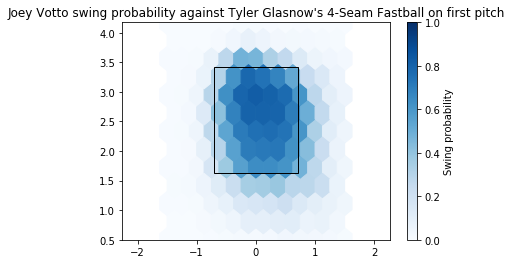

In [301]:
pitch_v_votto(607192, 'FF',0,0,'none')

In [303]:
playerid_lookup('kershaw','clayton')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2020.0


Gathering Player Data


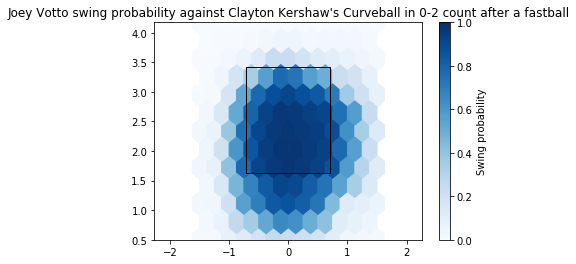

In [304]:
pitch_v_votto(477132, 'CU',2,0,'fb')

In [305]:
print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1647
           1       0.76      0.76      0.76      1151

    accuracy                           0.81      2798
   macro avg       0.80      0.80      0.80      2798
weighted avg       0.81      0.81      0.81      2798

